#### **GWAS thresh results**
13-10-2023

In [1]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(circlize)
library(ggrepel)
library(ComplexUpset)

options(bitmapType = 'cairo')
Sys.setlocale("LC_NUMERIC", "C")

corrplot 0.92 loaded


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




[1] "C"

In [2]:
color_tissues <- fread(sprintf('%scolor_tissues.txt', "~/tools/castom_cad_scz/jupyter_notebook/"), h=T, stringsAsFactors=F, data.table = F)

In [3]:
results_dir <- "/scratch/tmp/dolgalev/castom-igex-revision/results/gwas_thresh/"

In [4]:
load_res <- function(fold, tissue){
    
    df <- read.delim(sprintf('%s/resPrior_regEval_allchr.txt', fold), h = T, stringsAsFactors = F, sep = '\t')
    df$tissue <- tissue
    df$n_regSNPs <- NA
    
    # reg-SNPs per gene, regardless category
    coef <- get(load(sprintf('%s/resPrior_regCoeffSnps_allchr.RData', fold)))
    for(id_chr in 1:length(coef)){
        n_snps <- colSums(coef[[id_chr]]!=0)
        df$n_regSNPs[df$chrom == paste0('chr', id_chr)] <- n_snps
    }
    df$n_regSNPs[is.na(df$dev)] <- NA
    
    return(df)
}

create_cor2 <- function(tissues_name, res, id_z){
  
  cor_res <- diag(rep(1, length(tissues_name)), ncol = length(tissues_name))
  corpval_res <- diag(rep(1, length(tissues_name)),ncol = length(tissues_name))
  percint_res <- diag(rep(1, length(tissues_name)),ncol = length(tissues_name))
  
  for(i in 1:(length(tissues_name)-1)){
    ti <- res[res$tissue  %in%  tissues_name[i],]
    trest <- lapply((i+1):length(tissues_name), function(x) res[res$tissue  %in%  tissues_name[x],])
    gene_int <- lapply(trest, function(x) intersect(ti[,8], x[,8]))
    gene_union <- lapply(trest, function(x) union(ti[,8], x[,8]))
    
    # match
    ti_match <- lapply(gene_int, function(x) ti[match(x, ti[,8]), ])
    trest_match <- mapply(function(x,y) x[match(y, x[,8]), ], x = trest, y = gene_int, SIMPLIFY = F)
    
    percint_res[i, (i+1):length(tissues_name)] <- mapply(function(x,y) length(x)/length(y), x = gene_int, y = gene_union)
    
    tmp <- mapply(function(x,y) cor.test(x[,id_z],y[,id_z], method = 'pearson'), x = ti_match, y = trest_match, SIMPLIFY = F)
    
    cor_res[i, (i+1):length(tissues_name)] <- sapply(tmp, function(x) x$estimate)
    corpval_res[i, (i+1):length(tissues_name)] <- sapply(tmp, function(x) x$p.value)
    
  }
  cor_res <- cor_res + t(cor_res) - diag(diag(cor_res))
  corpval_res <- corpval_res + t(corpval_res) - diag(diag(corpval_res))
  percint_res <- percint_res + t(percint_res) - diag(diag(percint_res))
  
  rownames(cor_res) <- colnames(cor_res) <- rownames(corpval_res) <- colnames(corpval_res) <- tissues_name
  rownames(percint_res) <- colnames(percint_res) <- tissues_name
  
  return(list(cor = cor_res, pval = corpval_res, perc = percint_res))
  
}
                                                         
pl_corr2 <- function (res_cor, tissues_name){
    
    diag(res_cor$cor) <- NA
    col <- colorRampPalette(brewer.pal(9, "Oranges"))(100)
  
    corrplot(res_cor$cor, type = "upper", 
        tl.col = "black", col = c(col), mar = c(1, 1, 3, 6), cl.pos = "n",
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", number.cex = 0.8, tl.pos = "lt",
        na.label = "square", na.label.col = "darkgrey", is.corr = F, col.lim = c(0.995, 1.00), number.digits = 6)
   
    diag(res_cor$perc) <- NA
    col <- colorRampPalette(brewer.pal(9, "Greens"))(100)
    
    corrplot(res_cor$perc, type = "lower", tl.col = "black", 
        col = c(col), method = "color", tl.srt = 45,tl.pos = "n", cl.pos = "n",
        cl.align.text = "c", addCoef.col = "black", na.label = "square",
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8, col.lim = c(0.9, 1.0), number.digits = 6, add = TRUE)
}
                                                         
plot_R2_dist2 <- function(tissue_tmp, df_gene, df_summary, col_plot, save_file = NULL) {
    
  id <- names(which(table(df_gene$ensembl_gene_id[df_gene$reliable]) == length(unique(df_gene$tissue))))
  df_plot <- df_gene
  df_plot$tissue_name <- df_plot$tissue
  df_plot$tissue_name <- factor(df_plot$tissue_name, 
                                levels = df_summary$complete_name[df_summary$tissue == tissue_tmp])

  df_med <- df_plot %>% 
            filter(reliable) %>%
            group_by(tissue_name) %>% 
            summarise(med = median(dev_geno), med_test = median(test_dev_geno))

  pl_box_R2 <- ggplot(subset(df_plot, reliable), 
                      aes(x = tissue_name, y=dev_geno)) + 
    geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
                 fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
    ylab(expression(R^2))+ ggtitle('')+
    xlab('')+ theme_bw()+ 
    ggtitle('Final model\n ')+
    #scale_y_continuous(trans=weird)+
    geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
    theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
          text = element_text(size = 10),
          axis.text.y=element_text(size = 9, angle = 0, hjust = 1),
          axis.text.x=element_text(size = 10), legend.position = 'none')+
          coord_flip()

  pl_box_R2_test <- ggplot(subset(df_plot, reliable), 
                      aes(x = tissue_name, y=test_dev_geno)) + 
    geom_boxplot(width = 0.5, outlier.size = 0.3, alpha = 0.7, size = 0.3, 
                 fill = col_plot$color[col_plot$tissue == tissue_tmp])+ 
    ylab(expression(R[CV]^2))+ 
    xlab('')+ theme_bw()+ 
    #scale_y_continuous(trans=weird)+
    ggtitle('All genes')+
    geom_hline(yintercept = 0, color = 'darkgrey', linetype='dashed')+
    theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5), 
          text = element_text(size = 12),
          #axis.text.y=element_blank(),
          axis.text.x=element_text(size = 10), legend.position = 'none')+
          coord_flip()

  return(pl_box_R2_test)
}

In [5]:
pvals <- c("p01", "p005", "p001", "p0001", "p00001")
pvalstr <- c("0.1", "0.05", "0.01", "0.001", "0.0001")

common_name <- "/scratch/tmp/dolgalev/castom-igex-revision/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2"

folder_train_ac <- vector(mode = "character")
folder_train_bc <- vector(mode = "character")

folder_sample_ac <- vector(mode = "character")
folder_sample_bc <- vector(mode = "character")

name_t_ac <- vector(mode = "character")
name_t_bc <- vector(mode = "character")

for (i in 1:length(pvals)) {
  folder_train_ac <- c(folder_train_ac, sprintf("%s/Artery_Coronary/200kb/CAD_GWAS_bin_%s", common_name, pvals[i]))
  folder_train_bc <- c(folder_train_bc, sprintf("%s/Brain_Cortex/200kb/PGC_GWAS_bin_%s", common_name, pvals[i]))
  
  folder_sample_ac <- c(folder_sample_ac, sprintf("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", "Artery_Coronary"))
  folder_sample_bc <- c(folder_sample_bc, sprintf("/cloud/wwu1/h_fungenpsy/AGZiller_data/CASTOMiGEx/PriLer_PROJECT_GTEx/INPUT_DATA/Covariates/%s/covariates_EuropeanSamples.txt", "Brain_Cortex"))
  
  name_t_ac <- c(name_t_ac, sprintf("Artery Coronary (p <= %s)", pvalstr[i]))
  name_t_bc <- c(name_t_bc, sprintf("Brain Cortex (p <= %s)", pvalstr[i]))
}
                                                   
tissues_model_ac <- data.frame(tissue = name_t_ac, folder_sample = folder_sample_ac, folder_train = folder_train_ac)
tissues_model_bc <- data.frame(tissue = name_t_bc, folder_sample = folder_sample_bc, folder_train = folder_train_bc)

In [6]:
df <- list()
for(i in 1:nrow(tissues_model_ac)){
    tmp <- load_res(fold = tissues_model_ac$folder_train[i], tissue = tissues_model_ac$tissue[i])
    df[[i]] <- tmp
}
col_keep <- names(which(table(unlist(sapply(df, colnames))) == length(df)))
df <- lapply(df, function(x) x[, colnames(x) %in% col_keep])
df <- do.call(rbind, df)
df$reliable <- F
df$reliable[df$test_dev_geno>0 & df$dev_geno>0.01] <- T
df_gene_ac <- df

In [7]:
df <- list()
for(i in 1:nrow(tissues_model_bc)){
    tmp <- load_res(fold = tissues_model_bc$folder_train[i], tissue = tissues_model_bc$tissue[i])
    df[[i]] <- tmp
}
col_keep <- names(which(table(unlist(sapply(df, colnames))) == length(df)))
df <- lapply(df, function(x) x[, colnames(x) %in% col_keep])
df <- do.call(rbind, df)
df$reliable <- F
df$reliable[df$test_dev_geno>0 & df$dev_geno>0.01] <- T
df_gene_bc <- df

In [8]:
df_gene_ac = df_gene_ac[df_gene_ac$reliable, ]
df_gene_bc = df_gene_bc[df_gene_bc$reliable, ]

In [ ]:
df_gene_ac

In [9]:
cor_ac <- create_cor2(tissues_model_ac$tissue, df_gene_ac, id_z = 17)  # Index of `test_dev_geno` column
cor_bc <- create_cor2(tissues_model_bc$tissue, df_gene_bc, id_z = 17)

In [62]:
pdf(sprintf("%scorr_test_dev_geno_artery_coronary.pdf", results_dir), width = 9, height = 6, compress = F)
par(xpd = TRUE)
pl_corr2(cor_ac, tissues_name = tissues_id_ac)
dev.off()

Warning message in corrplot(res_cor$cor, type = "upper", tl.col = "black", col = c(col), :
“col.lim interval too wide, please set a suitable value”


png 
  2

In [63]:
pdf(sprintf("%scorr_test_dev_geno_brain_cortex.pdf", results_dir), width = 9, height = 6, compress = F)
par(xpd = TRUE)
pl_corr2(cor_bc, tissues_name = tissues_id_bc)
dev.off()

Warning message in corrplot(res_cor$cor, type = "upper", tl.col = "black", col = c(col), :
“col.lim interval too wide, please set a suitable value”
Warning message in corrplot(res_cor$perc, type = "lower", tl.col = "black", col = c(col), :
“col.lim interval too wide, please set a suitable value”


png 
  2

In [12]:
df_summary_ac <- df_gene_ac %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary_ac <- df_summary_ac[match(tissues_model_ac$tissue, df_summary_ac$tissue),]

for(i in 1:nrow(tissues_model_ac)){
    tmp <- read.table(tissues_model_ac$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary_ac$n_samples[i] <- nrow(tmp)
    
}

df_summary_ac <- df_summary_ac %>% rename(complete_name = tissue)
df_summary_ac$tissue <- "Artery_Coronary"
df_summary_ac$percentage <- as.numeric(sapply(df_summary_ac$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary_ac <- df_summary_ac %>% arrange(tissue, percentage)
rownames(df_summary_ac) <- NULL 
df_summary_ac$percentage <- paste0(df_summary_ac$percentage, "%")                                                         

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [13]:
df_summary_bc <- df_gene_bc %>% 
    group_by(tissue) %>% 
    summarise(n_genes = sum(reliable)) %>% 
    mutate(n_regSNPs = NA, frac_prior = NA, n_samples = NA)
df_summary_bc <- df_summary_bc[match(tissues_model_bc$tissue, df_summary_bc$tissue),]

for(i in 1:nrow(tissues_model_bc)){
    tmp <- read.table(tissues_model_bc$folder_sample[i], h=T, stringsAsFactors = F)
    df_summary_bc$n_samples[i] <- nrow(tmp)
    
}

df_summary_bc <- df_summary_bc %>% rename(complete_name = tissue)
df_summary_bc$tissue <- "Brain_Cortex"
df_summary_bc$percentage <- as.numeric(sapply(df_summary_bc$complete_name, function(x) strsplit(x, split = "[(%)]")[[1]][2]))   
df_summary_bc <- df_summary_bc %>% arrange(tissue, percentage)
rownames(df_summary_bc) <- NULL 
df_summary_bc$percentage <- paste0(df_summary_bc$percentage, "%")         

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [14]:
col_plot_ac <- color_tissues %>% filter(tissues %in% unique(df_summary_ac$tissue))
col_plot_bc <- color_tissues %>% filter(tissues %in% unique(df_summary_bc$tissue))

In [15]:
df_gene_ac_list <- list(Artery_Coronary = df_gene_ac[grepl("Artery Coronary", df_gene_ac$tissue),])
df_gene_bc_list <- list(Brain_Cortex = df_gene_bc[grepl("Brain Cortex", df_gene_bc$tissue),])

In [16]:
pdf(sprintf("%scorr_R2C_artery_coronary.pdf", results_dir), width = 7, height = 2.4, compress = F)
plot_R2_dist2(tissue_tmp = names(df_gene_ac_list)[1], df_gene = df_gene_ac_list[[1]], df_summary = df_summary_ac, col_plot = col_plot_ac)
dev.off()

png 
  2

In [17]:
pdf(sprintf("%scorr_R2C_brain_cortex.pdf", results_dir), width = 7, height = 2.4, compress = F)
(plot_R2_dist2(tissue_tmp = names(df_gene_bc_list)[1], df_gene = df_gene_bc_list[[1]], df_summary = df_summary_bc, col_plot = col_plot_bc))
dev.off()

png 
  2

In [18]:
p <- read.table(sprintf("%s/priorMatrix_chr1.txt.gz", common_name), header = TRUE)

ps <- colSums(p[, (ncol(p) - 9):ncol(p)])


for (c in 2:22) {
  p <- read.table(sprintf("%s/priorMatrix_chr%s.txt.gz", common_name, c), header = TRUE)
  
  ps <- ps + colSums(p[, (ncol(p) - 9):ncol(p)])
}

In [19]:
p <- rep(c("0.0001", "0.001", "0.01", "0.05", "0.1"), 2)
h <- c(rep("CAD", 5), rep("SCZ", 5)) 

In [20]:
phs <- data.frame(p_val = p, cohort = h, snps = ps)

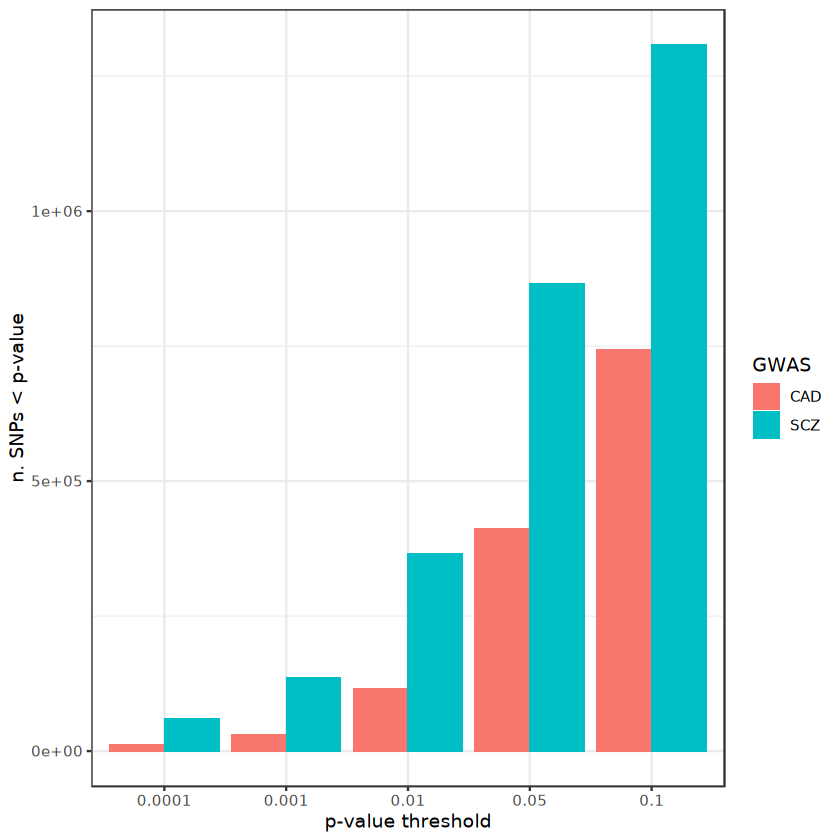

In [21]:
(
  g <- ggplot(phs, aes(x = p_val, y = snps, fill = cohort)) + 
    geom_col(position = "dodge") + 
    labs(x = "p-value threshold", y = "n. SNPs < p-value", fill = "GWAS") + 
    theme_bw()
)

In [22]:
ggsave(sprintf("%spval_thresh_n_snps.pdf", results_dir), width = 4, height = 5, dpi = 300, compress = F)